In [1]:
import pandas as pd
import numpy as np

In [2]:
skills = pd.read_csv('../data/processed/ds_skills.csv')
skills.head()

,index,Job Profile Skills
0,Requirements Analysis,59
1,Big Data Management,59
2,Big Data,58
3,Information Management,58
4,Technical Troubleshooting,58


In [3]:
skills.columns = ['skill', 'count']

In [4]:
skills.shape

(85, 2)

In [5]:
skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   skill   85 non-null     object
 1   count   85 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [6]:
skills.iloc[:10]

,skill,count
0,Requirements Analysis,59
1,Big Data Management,59
2,Big Data,58
3,Information Management,58
4,Technical Troubleshooting,58
5,Repository Management,58
6,Prototyping,58
7,Organizational Understanding,58
8,Metadata Repository,58
9,Query Tools,58


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
from wordcloud import WordCloud

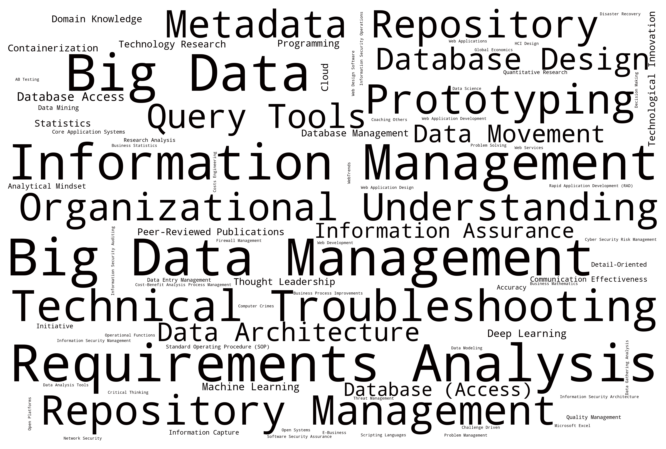

In [9]:
freqs = {}

for skill, count in zip(skills['skill'], skills['count']):
    
    freqs[skill] = count

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(background_color='white', width=3000, height=2000).generate_from_frequencies(freqs)

# set the word color to black
wordcloud.recolor(color_func = black_color_func)

plt.figure(figsize=(18,8))
plt.axis('off')
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")

In [10]:
import torch

In [11]:
import transformers as ppb

In [12]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel,
                                                    ppb.DistilBertTokenizer,
                                                    'distilbert-base-uncased')

In [13]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenized = skills['skill'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
max_len = 0

for i in tokenized.values:

    if len(i) > max_len:

        max_len = len(i)

padded = np.array([i + [0] * (max_len-len(i)) for i in tokenized.values])

In [17]:
model.to('cuda')
input_ids = torch.tensor(np.array(padded), device='cuda')

with torch.no_grad():

  last_hidden_states = model(input_ids)

In [20]:
features = last_hidden_states[0][:,0,:].to('cpu').numpy()

In [35]:
df = pd.concat([
    skills.drop('count', axis=1),
    pd.DataFrame(features)
],  axis=1)

df.shape

(85, 769)

In [37]:
from sklearn.cluster import KMeans

In [39]:
X = df.drop('skill', axis=1)

C:\Users\jpzam\miniconda3\envs\ds_rpg\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


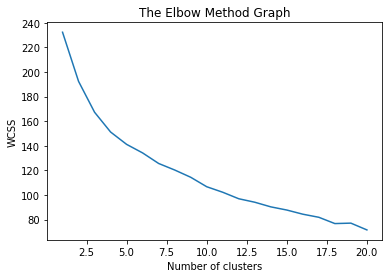

In [47]:
wcss = []

for i in range(1, 21):
    
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(X)
    
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 21),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
kmeans = KMeans(15)
y_kmeans = kmeans.fit_predict(X)

In [50]:
df['k_means_group'] = y_kmeans

In [52]:
groups = df[['skill', 'k_means_group']]

In [85]:
for group in groups['k_means_group'].sort_values().unique():
    print(f"Group {group + 1}:\n{groups[groups['k_means_group'] == group]['skill'].values}\n\n")

Group 1:
['Cloud' 'Statistics' 'Programming' 'Initiative' 'Accuracy']


Group 2:
['Requirements Analysis' 'Data Architecture' 'Data Movement'
 'Machine Learning' 'Domain Knowledge' 'Containerization'
 'Communication Effectiveness' 'Information Capture' 'Data Mining'
 'Research Analysis' 'AB Testing' 'Costs Engineering' 'Network Security'
 'Operational Functions' 'Problem Management' 'Process Management'
 'Threat Management' 'Problem Solving']


Group 3:
['Rapid Application Development (RAD)']


Group 4:
['Software Security Assurance' 'Information Security Auditing'
 'Cyber Security Risk Management' 'Cost-Benefit Analysis']


Group 5:
['Big Data' 'Web Applications' 'Web Development' 'Web Services'
 'WebTrends' 'Scripting Languages' 'Open Systems' 'Open Platforms'
 'Microsoft Excel']


Group 6:
['Big Data Management' 'Query Tools' 'Database Design'
 'Database Management' 'Core Application Systems' 'Data Entry Management'
 'Business Process Improvements' 'Web Application Development'
 'We